# Baseline Modeling
#### Robert Shaw
#### CS109a Project: Data Driven March Madness

---

### Load in Our Datasets and Functions

In [1]:
import march_madness_classes as mmc

# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
teams = pd.read_csv("datasets/kaggle_data/Teams.csv")
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")
tourney_data = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")
regular_data = pd.read_csv("datasets/kaggle_data/RegularSeasonCompactResults.csv")

In [71]:
tourney_arr = mmc.filter_into_seasons(tourney_data)
regular_arr = mmc.filter_into_seasons(regular_data)
seeds_arr = mmc.filter_into_seasons(seeds)
slots_arr = mmc.filter_into_seasons(slots)

seeds_1985 = seeds_arr[0]
slots_1985 = slots_arr[0]
tourney_1985 = tourney_arr[0]
regular_1985 = regular_arr[0]

---

### Transform the Stationary Distibution Data Into One DataFrame/CSV File

In [72]:
stationary_arr = []
for i in range(1985, 2017):
    df = pd.read_csv("datasets/our_data/markov_data/{}_stationary_distribution".format(i), index_col = 0)
    df.columns = [i]
    stationary_arr.append(df.transpose()) 

In [73]:
# concat into a 
stationary_df = pd.concat(stationary_arr)

In [74]:
# save as a csv
stationary_df.to_csv("datasets/our_data/stationary")

In [75]:
# everything appears to be working if they sum to one
stationary_df.sum(axis=1)

1985    1.0
1986    1.0
1987    1.0
1988    1.0
1989    1.0
1990    1.0
1991    1.0
1992    1.0
1993    1.0
1994    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
1999    1.0
2000    1.0
2001    1.0
2002    1.0
2003    1.0
2004    1.0
2005    1.0
2006    1.0
2007    1.0
2008    1.0
2009    1.0
2010    1.0
2011    1.0
2012    1.0
2013    1.0
2014    1.0
2015    1.0
2016    1.0
dtype: float64

---

### Get Predictors For Our Baseline Model

In [76]:
stationary = pd.read_csv("datasets/our_data/stationary", index_col =0)
avg_points_against =  pd.read_csv("datasets/our_data/avg_points_against", index_col =0)
avg_points_for = pd.read_csv("datasets/our_data/avg_points_for", index_col =0)
away_wins = pd.read_csv("datasets/our_data/away_wins", index_col =0)
bad_losses = pd.read_csv("datasets/our_data/bad_losses", index_col =0)
consistency= pd.read_csv("datasets/our_data/consistency", index_col =0)
dominance= pd.read_csv("datasets/our_data/dominance", index_col =0)
good_wins_matrix= pd.read_csv("datasets/our_data/good_wins_matrix", index_col =0)
rpi= pd.read_csv("datasets/our_data/rpi", index_col =0)
tough_wins= pd.read_csv("datasets/our_data/tough_wins", index_col =0)
win_percentage= pd.read_csv("datasets/our_data/win_percentage", index_col =0)
win_percentage_vs_tourney_teams_matrix= pd.read_csv("datasets/our_data/win_percentage_vs_tourney_teams_matrix", index_col =0)
wins_vs_tourney_teams= pd.read_csv("datasets/our_data/wins_vs_tourney_teams", index_col =0)

---

### Functions to go into our March Madness Classes Module

In [77]:
# extracting from the dataframe
def get_predictor(team_id, year, df):
    return df.loc[year, str(team_id)]

def get_predictor_dif(team_id_1, team_id_2, year, df):
    return df.loc[year, str(team_id_1)] - df.loc[year, str(team_id_2)]

def get_predictors(team_id, year, df_arr):
    row = np.zeros(len(df_arr))
    i = 0
    for df in df_arr:
        row[i] = get_predictor(team_id, year, df)
        i = i + 1
    return row

def get_predictors_dif(team_id_1, team_id_2, year, df_arr):
    row = np.zeros(len(df_arr))
    i = 0
    for df in df_arr:
        row[i] = float(get_predictor_dif(team_id_1, team_id_2, year, df))
        i = i + 1
    return row

In [78]:
# function to extract the y_values of the team with the min index winning
def extract_response(tourney_game_df):
    
    # response for a given year
    min_index_win = np.zeros(tourney_game_df.shape[0])
    i = 0
    for index, game in tourney_game_df.iterrows():
        if int(game["Prediction"]) == min(int(game["Strongseed Team"]), int(game["Weakseed Team"])):
            min_index_win[i] = 1 
        i = i + 1
           
    return min_index_win

# function to extract the y_values of the team with the min index winning
def extract_predictors(tourney_game_df, predictor_list, predictor_dfs, year):
    # buffer to hold our values
    pred_matrix = np.zeros((tourney_game_df.shape[0], len(predictor_list)))
    
    # fill predictor matrix
    for i in range(tourney_game_df.shape[0]):   
        # min and max index teams
        min_index_team = min(int(tourney_game_df.loc[i, "Strongseed Team"]), int(tourney_game_df.loc[i, "Weakseed Team"]))
        max_index_team = max(int(tourney_game_df.loc[i, "Strongseed Team"]), int(tourney_game_df.loc[i, "Weakseed Team"]))                  

        # fill matrix
        pred_matrix[i,  0] = min_index_team
        pred_matrix[i,  1] = max_index_team
        pred_matrix[i, 2:] = get_predictors_dif(min_index_team, max_index_team, year, predictor_dfs)

    # gen dataframe                       
    pred_df = pd.DataFrame(data = pred_matrix, columns = predictor_list)
                           
    return pred_df

In [79]:
def get_tourney_results(seeds, slots, raw_data):
    tourney = mmc.Tournament(seeds, slots, mmc.ActualTournament(raw_data))
    tourney.simulate_tournament()
    return tourney.entire_bracket

# get single years worth of games
def generate_single_year_of_games(year, seed_list, slot_list, tourney_data, predictors, predictor_dfs):
    # get results of the games
    tourney_results = get_tourney_results(seed_list, slot_list, tourney_data)
    
    # get predictors
    pred_df = extract_predictors(tourney_results, predictors, predictor_dfs, year)
    
    # get response
    resp_arr = extract_response(tourney_results)
    
    return pred_df, resp_arr

def generate_multiple_years_of_games(years, seed_list_arr, slot_list_arr, tourney_data_arr, predictors, predictor_dfs):
    min_year = 1985

    preds = pd.DataFrame({})
    resps = np.array([])
    
    for year in years:
        year_index = int(year) - min_year
        # generate 1 year of data
        pred_df, resp_arr = generate_single_year_of_games(year, 
                                                          seed_list_arr[year_index], 
                                                          slot_list_arr[year_index], 
                                                          tourney_data_arr[year_index],
                                                          predictors,
                                                          predictor_dfs)
        print year
        # add to list we are keeping 
        preds = pd.concat([preds, pred_df])
        resps = np.concatenate((resps, resp_arr))
        
    return preds, resps
        

In [80]:
column_names = ["min_index_id", "max_index_id", "wins_vs_tourney_teams dif", "stationary dif"]

In [81]:
tourney_arr = mmc.filter_into_seasons(tourney_data)
regular_arr = mmc.filter_into_seasons(regular_data)
seeds_arr = mmc.filter_into_seasons(seeds)
slots_arr = mmc.filter_into_seasons(slots)

In [121]:
predictor_dfs = [wins_vs_tourney_teams, stationary]

In [122]:
pred, resp = generate_multiple_years_of_games(range(1985, 2001), 
                                              seeds_arr, 
                                              slots_arr, 
                                              tourney_arr, 
                                              column_names, 
                                              predictor_dfs)

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


In [123]:
pred_df = pred.reset_index(drop=True)

In [181]:
pred_df.columns = column_names

In [182]:
resp_df = pd.DataFrame(data=resp, columns=["min_index_win"])

In [183]:
print pred_df.index
print resp_df.index

RangeIndex(start=0, stop=1008, step=1)
RangeIndex(start=0, stop=1008, step=1)


In [184]:
from sklearn.cross_validation import train_test_split

In [185]:
train_index, cross_index = train_test_split(pred_df.index, test_size = .25)

In [186]:
train_x = pred_df.loc[train_index]
train_y = resp_df.loc[train_index]
cross_x = pred_df.loc[cross_index]
cross_y = resp_df.loc[cross_index]

In [187]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [188]:
logistic_model = LogReg(C=100)
lda_model = LDA()
qda_model = QDA()

In [189]:
model = logistic_model
model.fit(train_x.iloc[:, 2:], train_y.values.T[0])
model.score(cross_x.iloc[:, 2:], cross_y)

0.6785714285714286

In [190]:
model = lda_model
model.fit(train_x.iloc[:, 2:], train_y.values.T[0])
model.score(cross_x.iloc[:, 2:], cross_y)

0.7142857142857143

In [191]:
train_x.head()

,min_index_id,max_index_id,dominance dif,stationary dif
496,1276.0,1329.0,-3.0,-0.001968
640,1211.0,1268.0,-6.0,-0.003239
678,1329.0,1448.0,2.0,0.001285
339,1114.0,1424.0,-7.0,-0.007440
464,1191.0,1431.0,-2.0,0.000494


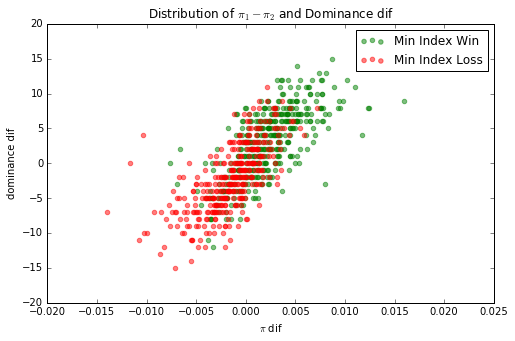

In [192]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

ax.scatter(train_x.iloc[train_y.values.T[0] == 1, 3], train_x.iloc[train_y.values.T[0] == 1, 2], color="g", alpha=.5, label="Min Index Win")
ax.scatter(train_x.iloc[train_y.values.T[0] == 0, 3], train_x.iloc[train_y.values.T[0] == 0, 2], color="r", alpha=.5, label="Min Index Loss")
ax.legend()

ax.set_title("Distribution of $\pi_1-\pi_2$ and Dominance dif")
ax.set_xlabel("$\pi$ dif")
ax.set_ylabel("dominance dif")

### Package Into a Model

In [193]:
class ModelPredictor(object):
    # init function
    def __init__(self, model, dfs_arr, year):
        self.model = model
        self.dfs_arr = dfs_arr
        self.year = year
        return
    
    # head to head predicitons
    def predict(self, team_1, team_2):
        team_1 = int(team_1)
        team_2 = int(team_2)
        
        # min and max index
        min_index_team = min(team_1, team_2)
        max_index_team = max(team_1, team_2)
        
        # get the x values
        row = get_predictors_dif(min_index_team, max_index_team, self.year, self.dfs_arr)

        # predict under model
        y_hat = model.predict(row.reshape(1,-1))
        
        if y_hat == 1:
            return min_index_team
        else:
            return max_index_team
        

In [194]:
year = 1992

seeds = seeds_arr[year - 1985]
slots = slots_arr[year - 1985]
resul = tourney_arr[year - 1985]

tourney_actual = mmc.Tournament(seeds, slots, mmc.ActualTournament(resul))
tourney_actual.simulate_tournament()

tourney_top_seed = mmc.Tournament(seeds, slots, mmc.BasicPredictor())
tourney_top_seed.simulate_tournament()

tourney_model = mmc.Tournament(seeds, slots, ModelPredictor(lda_model, predictor_dfs, year))
tourney_model.simulate_tournament()

In [195]:
tourney_model.score_model(tourney_actual, print_res=True)

Total Points  : 1320

Total Accuracy: 46 / 63 = 0.730158730159
R1    Accuracy: 26 / 32 = 0.8125
R2    Accuracy: 11 / 16 = 0.6875
R3    Accuracy: 5 / 8 = 0.625
R4    Accuracy: 2 / 4 = 0.5
R5    Accuracy: 1 / 2 = 0.5
R6    Accuracy: 1 / 1 = 1.0


(1320, 0.7301587301587301)

In [196]:
tourney_top_seed.score_model(tourney_actual, print_res=True)

Total Points  : 1220

Total Accuracy: 43 / 63 = 0.68253968254
R1    Accuracy: 24 / 32 = 0.75
R2    Accuracy: 11 / 16 = 0.6875
R3    Accuracy: 5 / 8 = 0.625
R4    Accuracy: 1 / 4 = 0.25
R5    Accuracy: 1 / 2 = 0.5
R6    Accuracy: 1 / 1 = 1.0


(1220, 0.6825396825396826)

In [140]:
score_mod = np.zeros(len(range(1985, 2001)))
accur_mod = np.zeros(len(range(1985, 2001)))

score_top = np.zeros(len(range(1985, 2001)))
accur_top = np.zeros(len(range(1985, 2001)))

In [141]:
i = 0
for year in range(1985, 2001):
    seeds = seeds_arr[year - 1985]
    slots = slots_arr[year - 1985]
    resul = tourney_arr[year - 1985]

    tourney_actual = mmc.Tournament(seeds, slots, mmc.ActualTournament(resul))
    tourney_actual.simulate_tournament()

    tourney_top_seed = mmc.Tournament(seeds, slots, mmc.BasicPredictor())
    tourney_top_seed.simulate_tournament()

    tourney_model = mmc.Tournament(seeds, slots, ModelPredictor(lda_model, predictor_dfs, year))
    tourney_model.simulate_tournament()
    
    score_mod[i], accur_mod[i] = tourney_model.score_model(tourney_actual, print_res=False)
    score_top[i], accur_top[i] = tourney_top_seed.score_model(tourney_actual, print_res=False)
    
    i = i + 1

In [142]:
print np.mean(score_mod)
print np.mean(accur_mod)

920.0
0.650793650794


In [143]:
print np.mean(score_top)
print np.mean(accur_top)

890.0
0.64880952381
